In [152]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader 
from torchvision import datasets
from torchvision.transforms import Resize, ToTensor, Compose, Normalize

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Device

In [153]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True
print(torch.cuda.get_device_properties(0))

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1080 Ti', major=6, minor=1, total_memory=11263MB, multi_processor_count=28)


## Dataset

In [154]:
# Normalize a tensor image with mean and standard deviation from ImageNet
transform = Compose([Resize((224, 224)), ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)).to(device)])

# Download train data
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

# Download test data
test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

Files already downloaded and verified
Files already downloaded and verified


In [155]:
n_classes = len(test_data.classes)
n_classes

batch_size = 256

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([256, 3, 224, 224])
Shape of y: torch.Size([256]) torch.int64


## ResNet block

In [156]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBlock, self).__init__()
        
        self.downsample = downsample
        
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.relu = nn.ReLU()

    def forward(self, X):
        res = X
        output = self.layers(X)

        if self.downsample:
            res = self.downsample(X)
        output += res
        output = self.relu(output)
        return output


## ResNet layer

In [157]:
class ResNetLayer(nn.Module):
    def __init__(self, block, n_blocks, in_channels, out_channels, stride):
        super(ResNetLayer, self).__init__()
        downsample = None

        if stride != 1 or out_channels != in_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        layers = []

        layers.append(block(in_channels, out_channels, stride, downsample))

        for i in range(n_blocks-1):
            layers.append(block(out_channels, out_channels))

        self.layers = nn.Sequential(*layers)
    
    def forward(self, X):
        return self.layers(X)


## ResNet

In [158]:
class ResNet(nn.Module):
    def __init__(self, architecture: int = 18, layer=[2, 2, 2, 2], channels: int = 3, n_classes: int = 100):
        super(ResNet, self).__init__()

        self.architecture = architecture
        self.in_channels = 64

        layers = []

        self.conv1 = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        block = ResNetBlock

        self.conv2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            ResNetLayer(block, layer[0], self.in_channels, 64, stride=1)
        )
 
        self.conv3 = ResNetLayer(block, layer[1], self.in_channels, 128, stride=2)

        self.conv4 = ResNetLayer(block, layer[2], 128, 256, stride=2)

        if architecture != 32:
            self.conv5 = ResNetLayer(block, layer[3], 256, 512, stride=2)
        
        
        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.classicicator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, n_classes),
            # nn.Softmax()
        )

    def forward(self, X):

        X = self.conv1(X)  
        X = self.conv2(X)
        X = self.conv3(X)
        X = self.conv4(X)
        
        if self.architecture != 32:
            X = self.conv5(X)

        X = self.avgpool(X)
        X = self.classicicator(X)
  
        return X


## For easier optimizer setup 

In [168]:
def setup_optimizer(to_optimize, optimizer = torch.optim.Adam, schedule = False, epochs = 8, lr = 0.001):
    optimizer = optimizer(params = to_optimize.parameters(), lr=lr)

    scheduler = None

    if schedule:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_dataloader))

    return optimizer, scheduler

In [177]:
def train(dataloader, model, loss_fn, optimizer, scheduler=None):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0

    # To memorize losses and learning rates
    current_train_loss_history = []
    current_lr_history = []

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if scheduler:
            current_lr_history.append(scheduler.get_last_lr()) # save learning rate 
            scheduler.step()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= len(dataloader) # calculate mean loss for epoch
    current_train_loss_history.append(train_loss) # save current mean loss 

    print(f"Train: Avg loss: {train_loss:>8f}")

    return current_train_loss_history, current_lr_history




def test(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    current_test_loss_history = []
    current_test_metric_history = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    current_test_loss_history.append(test_loss)
    current_test_metric_history.append(correct * 100)
    
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    print("_______________________________")

    return current_test_loss_history, current_test_metric_history
      

In [178]:
def train_loop(model, epochs, optimizer, scheduler=None):

    train_loss_history = []
    lr_history = []
    test_loss_history = []
    test_metric_history = []

    for i in range(epochs):

        print(f'Epoch {i+1}\n')

        train_history = train(train_dataloader, model, loss_fn, optimizer, scheduler)
        test_history = test(test_dataloader, model, loss_fn, optimizer)

        train_loss_history = np.append(train_loss_history, train_history[0])
        lr_history = np.append(lr_history, train_history[1])
        test_loss_history = np.append(test_loss_history, test_history[0])
        test_metric_history = np.append(test_metric_history, test_history[1])

    print('Finished')

    return train_loss_history, lr_history, test_loss_history, test_metric_history

# ResNet18

In [184]:
ResNet10 = ResNet(architecture=10, layer=[1, 1, 1, 1], n_classes=n_classes).to(device)

In [185]:
print(ResNet10)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): ResNetLayer(
      (layers): Sequential(
        (0): ResNetBlock(
          (layers): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (relu): ReLU()
        )
      )
    )
  )
  (conv3): ResNetLayer(
    (layers): Sequential(
      (0): ResNetBlock(
        (downsample): Sequential(
          (0):

In [186]:
x = torch.randn(5, 3, 224, 224).to(device)
print(type(x))
y = ResNet10(x).to(device)
print(y.shape)

<class 'torch.Tensor'>
torch.Size([5, 100])


In [187]:
loss_fn = nn.CrossEntropyLoss()
optimizer, scheduler = setup_optimizer(ResNet10, schedule = True, epochs = 8, lr = 0.001)

In [188]:
history = train_loop(ResNet10, epochs=8, optimizer=optimizer, scheduler=scheduler)

Epoch 1

Train: Avg loss: 3.896097
Test: 
 Accuracy: 14.6%, Avg loss: 3.631976
_______________________________
Epoch 2

Train: Avg loss: 3.204292
Test: 
 Accuracy: 23.3%, Avg loss: 3.117039
_______________________________
Epoch 3

Train: Avg loss: 2.621584
Test: 
 Accuracy: 28.3%, Avg loss: 2.903042
_______________________________
Epoch 4

Train: Avg loss: 2.132273
Test: 
 Accuracy: 42.0%, Avg loss: 2.227861
_______________________________
Epoch 5

Train: Avg loss: 1.762562
Test: 
 Accuracy: 43.7%, Avg loss: 2.142991
_______________________________
Epoch 6

Train: Avg loss: 1.436019
Test: 
 Accuracy: 54.1%, Avg loss: 1.662248
_______________________________
Epoch 7

Train: Avg loss: 1.144039
Test: 
 Accuracy: 58.8%, Avg loss: 1.478366
_______________________________
Epoch 8

Train: Avg loss: 0.969312
Test: 
 Accuracy: 60.3%, Avg loss: 1.430729
_______________________________
Finished


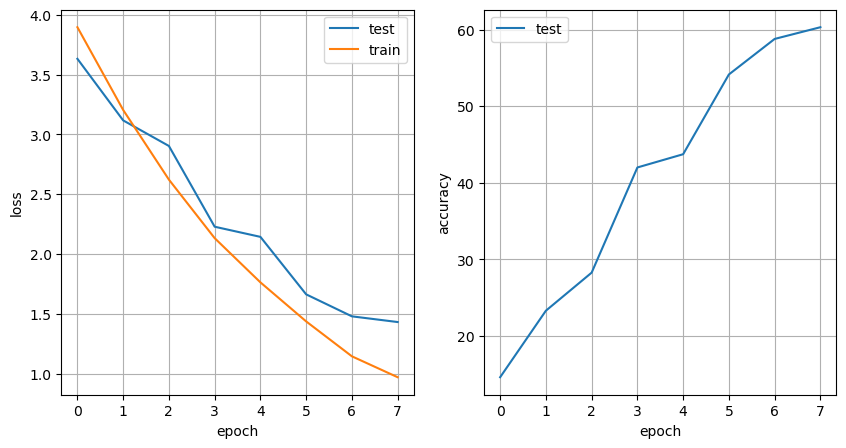

In [189]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history[2], label='test')
ax1.plot(history[0], label='train')
ax1.legend()
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()

ax2.plot(history[3], label='test')
ax2.legend()
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.grid()

## Learning rate

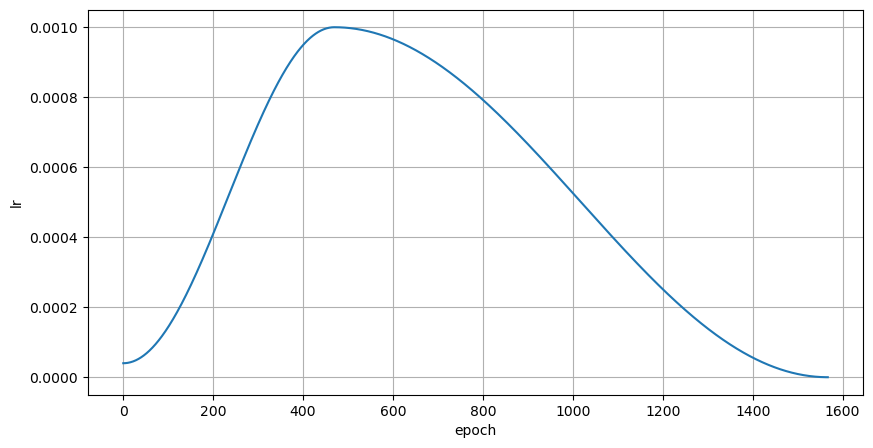

In [190]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(history[1])
ax.set_xlabel('epoch')
ax.set_ylabel('lr')
ax.grid()

In [146]:


ResNet10 = ResNet(layer=[1, 1, 1, 1], n_classes=n_classes).to(device)

In [147]:
ResNet10(x)

tensor([[-8.5749e-02,  1.3044e-01,  5.1242e-01, -5.4184e-01,  4.0094e-01,
          1.0441e-01,  4.3962e-02, -1.3897e-01,  1.2300e-01, -1.1895e-02,
          8.8606e-02,  7.4600e-03,  1.0169e-01,  2.1721e-01,  6.3575e-01,
          2.9283e-01,  1.0310e-01, -3.0897e-02, -3.1376e-02, -9.5071e-02,
          2.8357e-01, -3.0861e-01, -3.0142e-02, -5.2447e-02,  1.2868e-01,
         -1.6233e-01, -5.4925e-01, -4.0600e-01, -4.1898e-02, -1.3515e-01,
          5.2031e-02,  3.0481e-01, -3.1566e-01, -5.7924e-01, -2.3501e-01,
          4.3153e-01, -1.6975e-01, -3.6445e-02,  6.4493e-01, -7.8468e-02,
         -4.7496e-02,  1.6890e-01, -2.1073e-01,  5.3279e-02,  9.1930e-02,
         -1.8058e-01,  1.2106e-01,  3.1583e-01, -1.7001e-02,  2.5967e-01,
         -2.8845e-01,  7.2626e-01, -1.3174e-01,  2.8771e-01,  1.9972e-01,
         -5.5168e-02, -2.6253e-01, -5.7917e-01, -2.7948e-01,  1.4387e-01,
         -7.1704e-02,  8.9420e-03,  3.5099e-02,  5.7040e-01, -4.9377e-01,
         -4.6598e-01,  5.0529e-02,  4.

In [148]:
print(ResNet10)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): ResNetLayer(
      (layers): Sequential(
        (0): ResNetBlock(
          (layers): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (relu): ReLU()
        )
      )
    )
  )
  (conv3): ResNetLayer(
    (layers): Sequential(
      (0): ResNetBlock(
        (downsample): Sequential(
          (0):

In [149]:
optimizer_10 = torch.optim.Adam(ResNet10.parameters(), lr=0.01)

scheduler_10 = torch.optim.lr_scheduler.OneCycleLR(optimizer_10, 0.01, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

In [150]:
train_loss_history_10 = []
lr_history_10 = []
test_loss_history_10 = []
test_metric_history_10 = []

In [151]:
for i in range(epochs):
    print(f'Epoch {i+1}\n')
    train(train_dataloader, ResNet10, loss_fn, optimizer_10)
    test(test_dataloader, ResNet10, loss_fn, optimizer_10)
print('Finished')

Epoch 1

loss: 4.645724  [  256/50000]
loss: 3.624153  [25856/50000]
Test Error: 
 Accuracy: 17.5%, Avg loss: 3.431933
_______________________________
Epoch 2

loss: 3.282940  [  256/50000]
loss: 3.034834  [25856/50000]
Test Error: 
 Accuracy: 26.3%, Avg loss: 2.944956
_______________________________
Epoch 3

loss: 2.874835  [  256/50000]
loss: 2.643886  [25856/50000]
Test Error: 
 Accuracy: 33.9%, Avg loss: 2.554615
_______________________________
Epoch 4

loss: 2.331351  [  256/50000]
loss: 2.346120  [25856/50000]
Test Error: 
 Accuracy: 38.6%, Avg loss: 2.352518
_______________________________
Epoch 5

loss: 2.205017  [  256/50000]
loss: 2.009766  [25856/50000]
Test Error: 
 Accuracy: 42.5%, Avg loss: 2.183357
_______________________________
Epoch 6

loss: 1.724350  [  256/50000]
loss: 1.757657  [25856/50000]
Test Error: 
 Accuracy: 46.9%, Avg loss: 1.976022
_______________________________
Epoch 7

loss: 1.572499  [  256/50000]
loss: 1.513243  [25856/50000]
Test Error: 
 Accuracy: 5